# Computer Vision Project
#### Introduction to Machine learning course | Instructor: Dr. Fatemeh Mirsalehi

<font color='cyan'> Responsible TA: Amirhossein Razlighi </font>

In [1]:
%pip install torch torchvision numpy matplotlib Pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Section 1: Implementing a CNN from scratch! (30 points)

### 1.1 - Forward and Backward (20/30 pts)

__CNN__ s are powerfull tools to work with in the scope of _Computer Vision_. You have seen MLPs before and know how to do forward and backward pass on them. In this part, we want to create a convolutional layer (a simple one, of course!) just to understand well that how a Convolutional Layer works, behind the scenes. Then, we can simply use PyTorch's `Conv2D` layer for the rest of this project, because we understood that how Convolutions work, behind the scene!

__FORWARD PASS__:

In forward pass, you should apply the convolution operation on the input image. The convolution operation is as follows:

$$
\text{output}[i, j] = \sum_{k=0}^{K-1} \sum_{l=0}^{L-1} \text{input}[i+k, j+l] \times \text{kernel}[k, l]
$$

You can see a sample convolution operation (with a $3 \times 3$ kernel) in the following image:
<div style="text-align:center;">
  <img src="./Images/Conv.gif" />
</div>

Please note that, these are samples for you to understand the operation better. For _forward pass_ that you should implement, please notice that you should convolve the kernel along all $C$ channels of the input image. So, the output shape should be $(N, H_{out}, W_{out})$. These values are calculated as follows:

$$
H_{out} = \frac{H_{in} + 2 \times \text{padding}}{\text{stride} - HH} + 1
$$
$$
W_{out} = \frac{W_{in} + 2 \times \text{padding}}{\text{stride} - WW} + 1
$$


where $HH$ and $WW$ are the height and width of the kernel, respectively. __stride__ is the step size of the kernel, and __padding__ is the number of zeros that should be padded to the input image. Please also note that $b$ stands for bias, which is a scalar value that should be added to the output of the convolution operation. (for each kernel)

You can see a more detailed example, below:

<div style="text-align:center;">
  <img src="./Images/conv3.gif" />
</div>

__Backward Pass__:

In backward pass, you should calculate gradient of output with respect to the input image and the kernel. These gradients will be used in _optimization_ to update kernel weights. (You saw something similar, in using MLPs with gradient descent algorithm!). So, we need $d_x$, $d_w$ and $d_b$ in the backward pass. These are calculated as follows:

$$
dx_{padded} [n, :, i * stride: i * stride + HH, j * stride: j * stride + WW] += w[f] \times dout[n, f, i, j]
$$

$$
dw_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} x_{padded}[n, :, i * stride: i * stride + HH, j * stride: j * stride + WW] \times dout[n, f, i, j]  
$$

$$
db_{f} = \sum_{n=0}^{N - 1} \sum_{i=0}^{H_{out} - 1} \sum_{j=0}^{W_{out} - 1} dout[n, f, i, j]
$$

For better understanding of the backward pass, you can see the following image:

<div style="text-align:center;">
  <img src="./Images/backprop_cs231n.png" />
</div>


In [3]:
class MyConv:
    def __init__(self, stride, padding):
        self.stride = stride
        self.padding = padding
        self.cache = None
        self.dx = None
        self.dw = None
        self.db = None

    def forward(self, x, w, b):
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        pad = self.padding
        stride = self.stride
        H_out = (H + 2 * pad - HH) // stride + 1
        W_out = (W + 2 * pad - WW) // stride + 1

        x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')
        out = np.zeros((N, F, H_out, W_out))

        for n in range(N):
            for f in range(F):
                for k in range(H_out):
                    for l in range(W_out):
                        out[n, f, k, l] = np.sum(
                            x_pad[n, :, k*stride:k*stride+HH, l*stride:l*stride+WW] * w[f, :, :, :]
                        ) + b[f]

        self.cache = (x, w, b, x_pad)
        return out

    def backward(self, dout):
        x, w, b, x_padded = self.cache

        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        _, _, H_OUT, W_OUT = dout.shape

        dw = np.zeros_like(w)
        dx = np.zeros_like(x)
        db = np.zeros_like(b)
        dx_padded = np.zeros_like(x_padded)

        for n in range(N):
            for f in range(F):
                for i in range(H_OUT):
                    for j in range(W_OUT):
                        dw[f] += x_padded[n, :, i*self.stride:i*self.stride+HH, j*self.stride:j*self.stride+WW] * dout[n, f, i, j]
                        dx_padded[n, :, i*self.stride:i*self.stride+HH, j*self.stride:j*self.stride+WW] += w[f] * dout[n, f, i, j]
                db[f] += np.sum(dout[n, f, :, :])

        dx = dx_padded[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else dx_padded

        self.dx = dx
        self.dw = dw
        self.db = db
        return dx, dw, db

In [4]:
def rel_error(x, y):
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# A simple test for forward pass (DO NOT CHANGE)

x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

out = MyConv(stride=2, padding=1).forward(x, w, b)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# The outputted difference which is printed, should be around 1e-8
print ('Testing conv_forward_naive')
print ('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


In [6]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index

    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval

    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad

In [7]:
# A simple test for backward pass (DO NOT CHANGE)

x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(
    2,
)
dout = np.random.randn(4, 2, 5, 5)
conv = MyConv(stride=1, padding=1)

dx_num = eval_numerical_gradient_array(
    lambda x: conv.forward(x, w, b), x, dout
)
dw_num = eval_numerical_gradient_array(
    lambda w: conv.forward(x, w, b), w, dout
)
db_num = eval_numerical_gradient_array(
    lambda b: conv.forward(x, w, b), b, dout
)

out = conv.forward(x, w, b)
dx, dw, db = conv.backward(dout)

# Your printed errors should be around 1e-9
print("Testing conv_backward_naive function")
print("dx error: ", rel_error(dx, dx_num))
print("dw error: ", rel_error(dw, dw_num))
print("db error: ", rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  3.9010800222440555e-10
dw error:  1.3674324913325247e-09
db error:  2.2438929836576057e-11


### 1.2 - Visualizing Convolution results (10/30 pts)

In this part, we try to visualize the results of the convolution operation. We will 2 sample photos (in `Images/Sample`) and then we will use our `MyConv` class to apply some cool convolutions (and see their result on an image).

In [8]:
from PIL import Image

first_img, second_img = Image.open("./Images/Sample/Sharif_1.JPG"), Image.open(
    "./Images/Sample/Sharif_2.jpg"
)
first_img = first_img.resize((256, 256))
second_img = second_img.resize((256, 256))

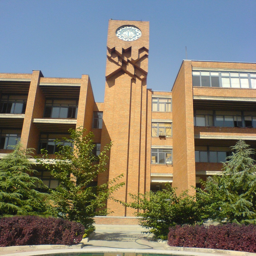

In [9]:
first_img

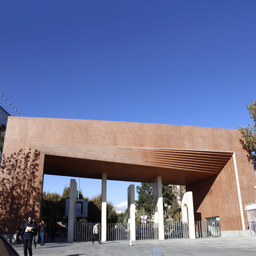

In [10]:
second_img

Convolutions have some interesting usages in image processing. For example, you can extract edges from an image by applying a convolution with a kernel that detects edges. Or you can convolve a specific kernel with your image to make it grayscale or blurred! Look at the definitions below:

__Edge Detection Kernel__:

_Sobel_ is one of the most famous edge detection kernels. It has two kernels, one for detecting vertical edges and the other for horizontal edges. You can see the kernels below:
$$
\text{Sobel}_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

$$
\text{Sobel}_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$


__Grayscale Kernel__:

You can simply convolve the image with the following kernel to make it grayscale:

$$
\text{Grayscale\_across\_R} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.3 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

$$
\text{Grayscale\_across\_G} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.6 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

$$
\text{Grayscale\_across\_B} = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

(Convolve each kernel with its corresponding channel)

__Blurring Kernel__:

One of the famous kernels to blur an image is _Gaussian Blur_. You can see the kernel below:

$$
\text{Gaussian\_Blur} = \frac{1}{16} \times \begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$


In [11]:
img_size = 256

x = np.zeros((2, 3, img_size, img_size))
x[0] = np.array(first_img).transpose(2, 0, 1)
x[1] = np.array(second_img).transpose(2, 0, 1)

# Defining convolution kernels
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
grayscale_R = np.array([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
grayscale_G = np.array([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
grayscale_B = np.array([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])
gaussian_blur = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])

# A convolution weight, holding 4 filters 3x3
w = np.stack([
    np.stack([sobel_x, sobel_x, sobel_x]),
    np.stack([sobel_y, sobel_y, sobel_y]),
    np.stack([grayscale_R, grayscale_G, grayscale_B]),
    np.stack([gaussian_blur, gaussian_blur, gaussian_blur])
])

b = np.array([0, 128, 128, 0])  # todo: chatgpt says [0,0,0,0]. what to do?

conv = MyConv(stride=1, padding=1)
out = conv.forward(x, w, b)

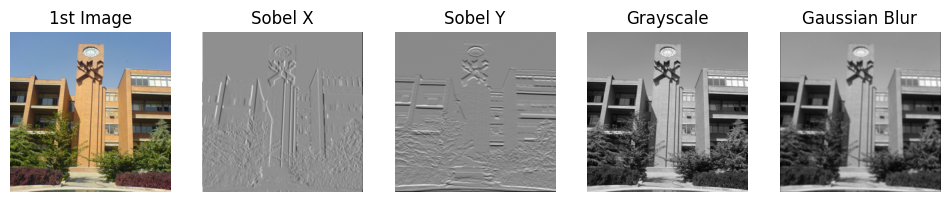

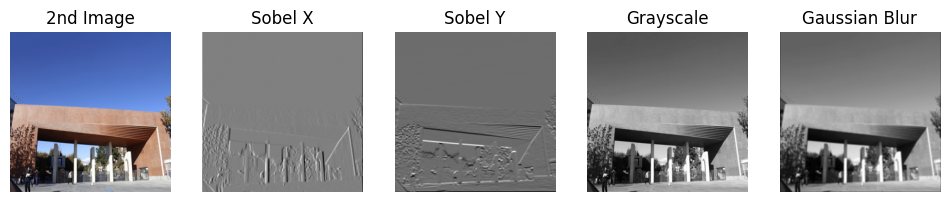

In [72]:
titles = ['Sobel X', 'Sobel Y', 'Grayscale', 'Gaussian Blur']

plt.figure(figsize=(12, 6))
plt.subplot(2, 5, 1)
plt.imshow(first_img)
plt.title('1st Image')
plt.axis('off')
for i in range(4):
    plt.subplot(2, 5, i + 2)
    plt.imshow(out[0, i, :, :], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 5, 1)
plt.imshow(second_img)
plt.title('2nd Image')
plt.axis('off')
for i in range(4):
    plt.subplot(2, 5, i + 2)
    plt.imshow(out[1, i, :, :], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

Now that we understood how Convolution works, we proceed further to use it in our models to perform a desired and specific task! We can use PyTorch's `Conv2D` layer from now on, because we understood how Convolutions work, behind the scene!

## Section 2: Neural Style Transfer (90 points)

In this part, we are going to implement a famous technique in the field of _Computer Vision_ called __Neural Style Transfer__. This technique is used to apply the style of a specific image to another image. For example, you can apply the style of a famous painting to your photo! Let's get started!

### 2.1 - Importing Libraries

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [18]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
torch.set_default_device(device)
device

device(type='cpu')

### 2.2 - Loading Images and doing some Preprocessing (5/90 pts)

In this part, you should load the content and style images and preprocess them. Preprocessing includes resizing the images to a specific size, normalizing them, and converting them to PyTorch tensors. You can use `torchvision.transforms` to do these tasks.

In [19]:
img_size = 512 if not device == "cpu" else 256

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

style_image = load_image('./Images/Neural_Transfer/style.jpeg')
content_image = load_image('./Images/Neural_Transfer/Content.jpeg')

style_image.size(), content_image.size()

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

Here, you should implement a helper function to show you images (which are now in form of pytorch tensors) in the notebook. You can use `torchvision.transforms.ToPILImage` to convert a tensor to a PIL image.

In [21]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

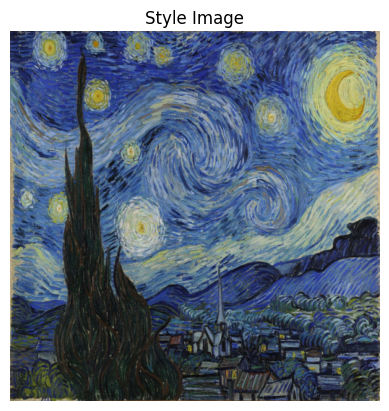

In [22]:
imshow(style_image, "Style Image")

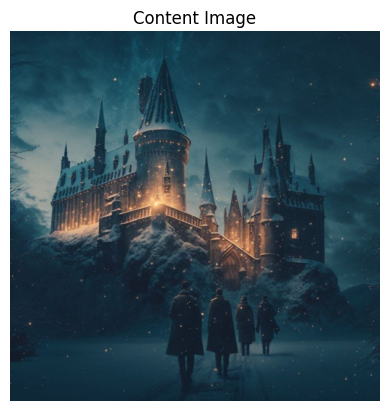

In [23]:
imshow(content_image, "Content Image")

### 2.2 - VGG19 Model (15/90 pts)

One of the important parts of Neural Style Transfer is to use a pre-trained model to extract features from the content and style images. Here, we are going to use a pre-trained VGG19 model to extract features from the images. You can use `torchvision.models.vgg19` to load the model. You should also freeze the weights of the model to prevent them from updating during the optimization process.

<div style="text-align:center;">
  <img src="./Images/VGG-19.png" />
</div>

But what is VGG model? Let's see with a simple experiment:

In [28]:
import certifi
import os

os.environ['SSL_CERT_FILE'] = certifi.where()

Here, please load `VGG19` model from `torchvision.models` and see the architecture of the model. You may need models `features` and `classifier` part stored seperately as we will discuss these both parts.

In [29]:
vgg_model = vgg19(pretrained=True).to(device)
vgg_model_features = vgg_model.features
vgg_model_classifier = vgg_model.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 52.9MB/s]


In [30]:
import torchsummary
torchsummary.summary(vgg_model, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

Please briefly explain what is a VGG model used for and what does each `features` and `classifier` part, represent?

**Your Answer:**

The VGG (Visual Geometry Group) model is a convolutional neural network architecture. It is widely used in computer vision tasks such as image classification, feature extraction, object detection, and image segmentation.

- Features: This part consists of a series of convolutional layers followed by max-pooling layers. The primary role of the features part is to extract spatial hierarchies of features from the input images.
- Classifier: This part consists of fully connected layers (aka dense layers). This part's role is to take the high-level features extracted by the convolutional layers and perform the final classification.

Now, we are going to give a sample image `Images/Neural_Transfer/Car.jpeg` to the model, see the output for classification and also visualize the feature maps (outputs of each convolutional layer) to see what's going on!

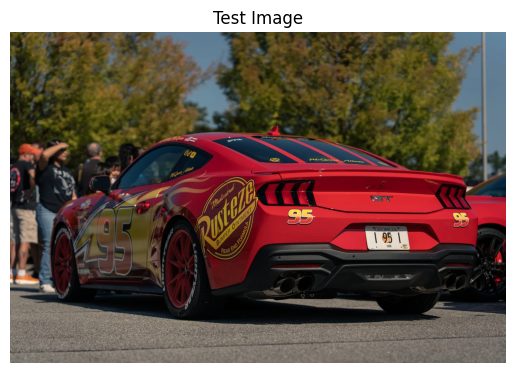

Predicted class for test image: tensor([817])


In [34]:
vgg_test_image = Image.open("./Images/Neural_Transfer/Car.jpeg")
plt.imshow(vgg_test_image)
plt.title('Test Image')
plt.axis('off')
plt.show()


preprocess_vgg = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess_vgg(vgg_test_image).unsqueeze(0).to(device)
vgg_model.eval()
with torch.no_grad():
    output = vgg_model(input_tensor)
_, predicted = torch.max(output, 1)
print(f'Predicted class for test image: {predicted}')

As you can see, the output of the classifier is an integer. This integer is actually the **class number** in _Image Net_ dataset. Let's get the name of the class:

In [35]:
import requests

class_idx = requests.get(
    "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
).json()

# Get the class name
class_name = class_idx[predicted]

print(f"Predicted class: {class_name}")

Predicted class: sports car


Now that we understood the architecture of VGG, and also the output of its classifier, it's time to extract features from the images! And see what's going on in the feature maps!

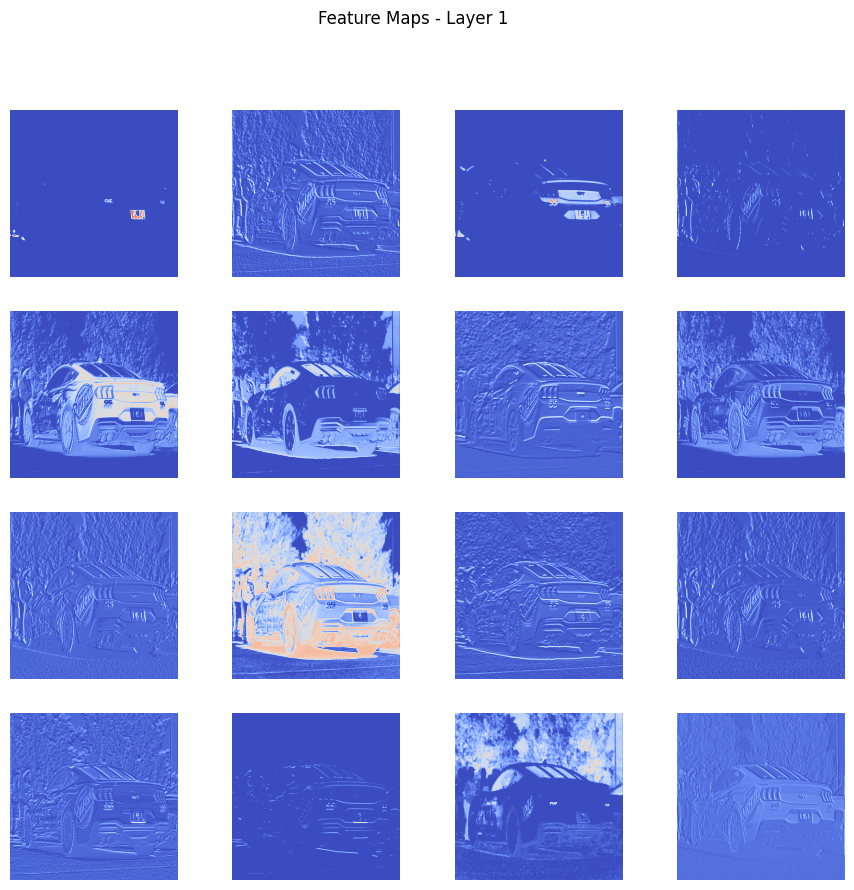

In [74]:
def get_feature_maps(model, x):
    feature_maps = []
    for layer in model:
        x = layer(x)
        if isinstance(layer, nn.Conv2d):
            feature_maps.append(x)
    return feature_maps

def visualize_feature_maps(feature_maps):
    for i, fm in enumerate(feature_maps):
        fm = fm.squeeze(0)
        plt.figure(figsize=(10, 10))
        for j in range(min(16, fm.shape[0])):
            ax = plt.subplot(4, 4, j + 1)
            plt.imshow(fm[j].cpu().detach().numpy(), cmap='coolwarm')
            ax.axis('off')
        plt.suptitle(f"Feature Maps - Layer {i + 1}")
        plt.show()

feature_maps = get_feature_maps(vgg_model_features, input_tensor)
visualize_feature_maps(feature_maps)

It's fun too look under the hood, isn't it? As you can see, we can guess what are the learned features in each layer if the network (at least in the first layers). For example, in the first layer, the network learns to detect edges, and in the second layer, it learns to detect simple shapes. In the deeper layers, the network learns to detect more complex features.

### 2.3 - Content and Style Loss (15/90 pts)

In order to learn the correct image and keep the content of the original image while applying the style of the seconf image, we need 2 losses: 1. Content Loss and 2. Style Loss. Let's delve into each one!

**Content Loss** is responsible for keeping the content of the original image. It is calculated as the mean squared error between the feature maps of the original image and the generated image.

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        ... #TODO

    def forward(self, input):
        #TODO
        pass

**Style Loss** is responsible for applying the style of the second image to the generated image. It is calculated as the mean squared error between the Gram matrices of the feature maps of the second image and the generated image.

In [ ]:
def gram_calculator(input):
    """
    Calculate the normalized Gram Matrix of a given input
    """
    # TODO
    pass

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        ...  # TODO

    def forward(self, input):
        # TODO
        pass

Now, we use `features` part of the VGG model to extract features from the content and style images. Then, we calculate the content and style loss using the extracted features.

In [ ]:
cnn = ... #TODO: Get the `features` part of the VGG19 model

In [ ]:
cnn_normalization_mean = torch.tensor(
    [0.485, 0.456, 0.406]
)  # Normalization mean for the VGG19 model
cnn_normalization_std = torch.tensor(
    [0.229, 0.224, 0.225]
)  # Normalization std for the VGG19 model


# Normalize the images in order to feed it to the VGG19 model
...

Please note that after which layers you should calculate the content loss and after which ones, you should calculate the style loss. Use the layer names you saw earlier in the `torchsummary` output for VGG19 model.

In [ ]:
content_layers_default = [...]  # TODO
style_layers_default = [...]  # TODO

#TODO: any processes you want to add and/or helper functions

In [ ]:
# Plot the input image to the model
# TODO

(15/90 pts) Now, we need to define our optimizer. We use `LBFGS` optimizer. Let's get familiar with this optimizer a little bit:

Let's use this optimizer to optimize a simple function $f(x) = x^2$. We want to find the minimum of this function using `LBFGS` optimizer. First, you should initialize a tensor $x$ with a random value. Then, you should define a closure function that calculates the value of the function and its gradient. Finally, you should use the `step` method of the optimizer to update the value of $x$.

And lastly, you should generate an animation using `matplotlib.animation` to show how the value of $x$ changes during optimization.

In [ ]:
import matplotlib.animation as animation
from torch.optim import LBFGS
import IPython.display as display


# TODO: Define a simple quadratic function
...


# Initialize a tensor with a single random value (e.g. 5.0/7.0/10.0/...)
x = ...

optimizer = ...

#TODO: Implement the optimization loop and animate the results
...

(35/90 pts) Now, let's use this optimizer to optimize our `input_image` to minimize the content and style loss. You should define a closure function that calculates the content and style loss and their gradients. Then, you should use the `step` method of the optimizer to update the value of the `input_image`. Please also **note** that you should use a weighted sum of the content and style loss to optimize the input image. (weight of each loss is a hyperparameter)

In [ ]:
# Train your model using LBFGS optimizer and 2 implemented losses (style loss and content loss)
# You should report the `style loss`, `content loss`, and `total loss` for each iteration. Note that `total loss`
# is the sum of `style loss` and `content loss` with some weights (alpha and beta) which you should tune them.
# Also, please plot the image each 50 iterations.
# An important note is that your optimizer might change the values of the image tensor in a way that the pixel values
# are no longer in the range of [0, 1] (in normalized format). So, you should clip the values of the image tensor
# to be in the range of [0, 1] after each iteration, to prevent any problems occuring to your image.
# TODO
...

Now, let's see the result of optimization process on our `input_image`.

In [ ]:
# TODO: Plot the final image
...

(5/90 pts) Also, let's plot our `style_losses`, `content_losses` and `total_losses` to see how they change during the optimization process.

In [ ]:
#TODO: Plot the total weighted loss w.r.t. the iteration number
...

In [ ]:
# TODO: Plot the style loss w.r.t. the iteration number

In [ ]:
# TODO: Plot the content loss w.r.t. the iteration number